
# Monte Carlo calculations of $\pi$


*Monte Carlo methods* are a broad class of computational algorithms that rely 
on repeated random sampling to obtain numerical results. The underlying concept 
is to use randomness to solve deterministic problems.

As an illustration of the idea, let's
consider the following Monte Carlo algorithm for calculating the
value of $\pi$:


> A quarter of a circle of radius $r = 1$ (with the area $A_c = \frac{\pi}{4}$)
> is inscribed in a square with the side length $l = 1$ (with the area $A_s = 1$),
> as shown in the first plot below. We generate uniformly distributed random points
> inside the unit square, that is we generate pars of uniformly distributed random
> numbers, $x$ and $y$, such that $0 \le x, y \le 1$. We count the fraction, $\nu$,
> of random points that lands inside the circle, that is such points where $x^2 + y^2 \le 1$.
> Since the number of uniformly distributed random points inside any shape is proportianal
> to its area, the fractions of of points inside the quater circle $$\nu = \frac{A_c}{A_s} = \frac{\pi}{4}.$$
> Thus, calculating $\nu$, we get the following estimate for $\pi$: $$pi = 4 \nu. $$


In this notes we implement the Monte Carlo algorithm described above and investigate its convergence properties.


#### 0. Load the required packages.

In [1]:

using Random: seed!           # only load the function to seed a random number generator
using PyPlot
using Statistics: mean, std   # only load the functions to calculate the mean and the standard deviation


Sketch the setup:

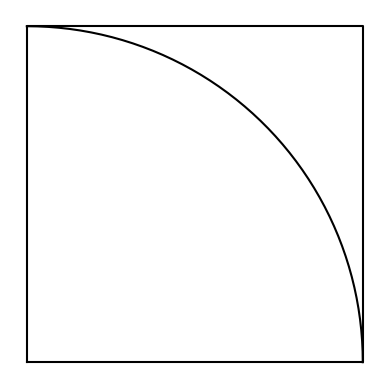

In [2]:

phi = range(0.0, pi/2, 50)
plot(cos.(phi), sin.(phi), color="black")
plot([0.0, 1.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0], color="black")
axis("off")
axis("square");


#### 1. Write a Julia function, `mcpi`,  that accepts a number of Monte Carlo steps $m$, and returns the estimate of `pi`

In [3]:

""""
    pi_est = mcpi(m)

Monte Carlo calculation of the base of nature logarithm aka Euler''s number
"""
function mcpi(m)
    s = 0
    for i = 1:m
        x, y = rand(2)
        if x^2 + y^2 <= 1.0
            s += 1
        end
    end
    return 4*s/m
end

mcpi


#### 2. Initialize the default random number generator, so that the calculation can be reproduced

Choose your own seed.

In [4]:

seed = 1
seed!(seed)

Random.TaskLocalRNG()


#### 3. The plan of the numerical experiments

Run multiple Monte Carlo experiments calculating $\pi$. In each subsequent experiment
double the number of the Monte Carlo steps.
For a selected number of Monte Carlo steps, 
repeat the calculations `k` times, obtaining `k` (slightly) different results for $\pi$.
Use the mean of those results as an estimation for $\pi$.
Use the standard deviation of the results as an estimation of the error of Monte Carlo calculations. 


#### 4. Assign parameters and prealocate working arrays

In [5]:

n = 12                  # the number of experiments
nps = zeros(Int64, n)   # the numbers of MC steps in each experiment
pis = zeros(n)          # the estimations of `pi` obtained in each experiment 
pistds = zeros(n);      # the stds of estimations

In [6]:

k = 256               # the number of MC runs with a fixed number of MC steps
res = zeros(k)        # storage for the results of `k' MC runs
ns = zeros(Int64, k); # working array of integers


#### 4. Run the calculations

In [7]:

@time for i = 1:n
    nps[i] = 2^(i+10)
    @info i, nps[i]
    fill!(ns, nps[i])  # fill the array `ns` with values of np[i]
    res .= mcpi.(ns)   # run mce() k times and store the results to array `res`
    pis[i] = mean(res)
    pistds[i] = std(res, mean=pis[i])/sqrt(k)  # the stds
end

[ Info: (1, 2048)
[ Info: (2, 4096)
[ Info: (3, 8192)
[ Info: (4, 16384)
[ Info: (5, 32768)
[ Info: (6, 65536)
[ Info: (7, 131072)
[ Info: (8, 262144)
[ Info: (9, 524288)
[ Info: (10, 1048576)
[ Info: (11, 2097152)
[ Info: (12, 4194304)


 66.205545 seconds (4.30 G allocations: 160.063 GiB, 15.82% gc time, 2.05% compilation time)


In [8]:
pis

12-element Vector{Float64}:
 3.13958740234375
 3.140117645263672
 3.1408233642578125
 3.1411685943603516
 3.1421961784362793
 3.1419432163238525
 3.1415847539901733
 3.141285538673401
 3.141743779182434
 3.1416588574647903
 3.141558662056923
 3.1415726728737354


Plot in the same figure the absolute errors of the results of Monte Carlo calculations, 
`abs.(pis .- pi)`, and the standard deviations of the results, `pistds`, vs. the number
of Monte Carlo steps.

The a proper type of your plot (linear, semilog, loglog, etc). Provide grid, axes labels, legend, and title.

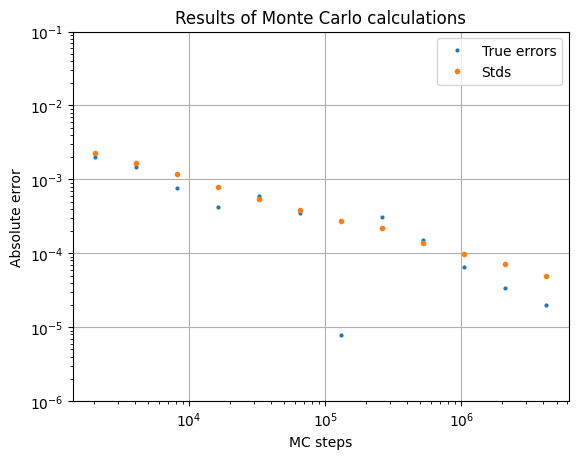

In [9]:

loglog(nps, abs.(pis .- pi), label="True errors", marker="o", markersize=2, linestyle="none")
loglog(nps, pistds, label="Stds", marker="o", markersize=3, linestyle="none")
ylim(1e-6, 1e-1)
grid(true)
xlabel("MC steps")
ylabel("Absolute error")
title("Results of Monte Carlo calculations")
legend();


The graph provides convincing arguments that the standard deviations of the results of Monte Carlo runs
can serve as an (over)estimation of the true absolute errors. The latter are never known for 'real-life' 
calculations whereas the former is a part of the results of the calculations.


#### 5. Find the dependence: standard deviations of the results of Monte Carlo runs vs the number of Monte Carlo steps

The last plot suggests a power law for the dependence of standar deviation vs the number of MC steps, $std \sim N^\beta$.
Use linear regression to find $\beta$.

In [10]:

function linear_regression(x, y)
    np = length(x)
    xbar = sum(x)/np
    ybar = sum(y)/np
    x2 = sum((x .- xbar) .^ 2)
    beta = sum((y .- ybar) .* (x .- xbar))/x2
    alpha = ybar - beta*xbar
    sigma = sqrt(sum((y .- alpha .- beta .* x) .^ 2)/((np - 2)*x2))
    return alpha, beta, sigma
end

linear_regression (generic function with 1 method)

In [11]:

alpha, beta, sigma = linear_regression(log.(nps), log.(pistds));


Print the results, rownding to a meaningful value of significant digits:

In [12]:

round(beta, sigdigits=2)

-0.5

In [13]:
round(sigma, sigdigits=1)

0.005


#### 6. Plot the results of MC simulations.

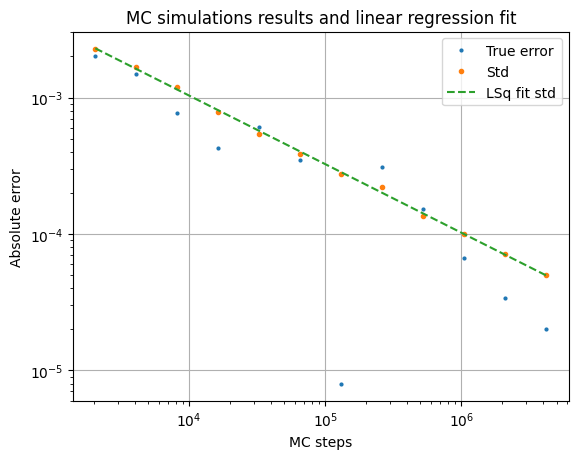

In [14]:

loglog(nps, abs.(pis .- pi), label="True error", marker="o", markersize=2, linestyle="none")
loglog(nps, pistds, label="Std", marker="o", markersize=3, linestyle="none")
loglog(nps, exp.(alpha .+ beta .* log.(nps)), label="LSq fit std", linestyle="dashed")
grid(true)
xlabel("MC steps")
ylabel("Absolute error")
title("MC simulations results and linear regression fit")
legend();


#### 7. Conclusions


The graph demonstrates that 

$$s \sim \frac{1}{\sqrt{N_{mc}}} ,$$

where $N_{mc}$ is the number of Monte Carlo steps. That is the dependence that is typical for MC simulations.